# Optimising the coupling coefficients of the Von Karman plate model

- order: 4

We can also optimise the non-linearity part of the plate model, that is the coupling coefficients.


In [ ]:
# | hide

import jax
import jax.numpy as jnp
import jax.scipy.signal as jsig
import numpy as np
import optax
from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm

from jaxdiffmodal.excitations import create_1d_raised_cosine
from jaxdiffmodal.ftm import (
    PlateParameters,
    damping_term_simple,
    stiffness_term,
)
from jaxdiffmodal.losses import (
    spectral_convergence_loss,
    spectral_wasserstein,
)
from jaxdiffmodal.num_utils import (
    compute_coupling_matrix_numerical,
    multiresolution_eigendecomposition,
)
from jaxdiffmodal.sv import (
    make_vk_nl_fn,
    solve_tf_excitation,
)
from jaxdiffmodal.utils import compute_spectrogram, display_audio_with_title, safe_log

Again, we generate a target simulation of the plate. We define the parameters of the plate and the excitation.

In [ ]:
# | code-fold: true

n_modes = 20
sampling_rate = 44100
sampling_period = 1 / sampling_rate
h = 0.004  # grid spacing in the lowest resolution
nx = 50  # number of grid points in the x direction in the lowest resolution
ny = 75  # number of grid points in the y direction in the lowest resolution
levels = 2  # number of grid refinements to perform
amplitude = 0.5
params = PlateParameters(
    E=2e12,
    nu=0.3,
    rho=7850,
    h=5e-4,
    l1=0.2,
    l2=0.3,
    Ts0=100,
)
force_position = (0.05, 0.05)
readout_position = (0.1, 0.1)

In [ ]:
# | code-fold: true

# boundary conditions for the transverse modes
bcs_phi = np.array(
    [
        [1e15, 0],
        [1e15, 0],
        [1e15, 0],
        [1e15, 0],
    ]
)
# boundary conditions for the in-plane modes
bcs_psi = np.array(
    [
        [1e15, 1e15],
        [1e15, 1e15],
        [1e15, 1e15],
        [1e15, 1e15],
    ]
)

psi, zeta_mu_squared, nx_final, ny_final, h_final, psi_norms = (
    multiresolution_eigendecomposition(
        params,
        n_modes,
        bcs_psi,
        h,
        nx,
        ny,
        levels=2,
    )
)

phi, lambda_mu_squared, nx_final, ny_final, h_final, phi_norms = (
    multiresolution_eigendecomposition(
        params,
        n_modes,
        bcs_phi,
        h,
        nx,
        ny,
        levels=2,
    )
)

H = compute_coupling_matrix_numerical(
    psi,
    phi,
    h_final,
    nx_final,
    ny_final,
)
e = params.E / (2 * params.rho)
H = H * np.sqrt(e)
lambda_mu = jnp.sqrt(lambda_mu_squared)

Refining grid to h = 0.002, nx = 100, ny = 150
Refining grid to h = 0.002, nx = 100, ny = 150


In [ ]:
# | code-fold: true

# generate a 1d raised cosine excitation
rc = create_1d_raised_cosine(
    duration=1.0,
    start_time=0.001,
    end_time=0.003,
    amplitude=amplitude,
    sample_rate=44100,
)

phi_reshaped = np.reshape(
    phi,
    shape=(ny_final + 1, nx_final + 1, n_modes),
    order="F",
)

mode_gains_at_pos = phi_reshaped[
    int(force_position[1] * ny_final),
    int(force_position[0] * nx_final),
    :,
]

mode_gains_at_readout = phi_reshaped[
    int(readout_position[1] * ny_final),
    int(readout_position[0] * nx_final),
    :,
]
# the modal excitation needs to be scaled by A_inv and divided by the density
mode_gains_at_pos_normalised = mode_gains_at_pos / params.density
modal_excitation_normalised_short = rc[: 4410 * 3, None] * mode_gains_at_pos_normalised
modal_excitation_normalised_long = rc[:44100, None] * mode_gains_at_pos_normalised

In [ ]:
# | hide

mask = H == 0


def get_H_opt(pars):
    H_opt = pars["H_opt"].at[mask].set(0.0)
    return H_opt * 1e9


omega_mu_squared = stiffness_term(params, lambda_mu)
gamma2_mu = damping_term_simple(jnp.sqrt(omega_mu_squared))


def simulate_vkplate(pars, modal_excitation_normalised):
    _, modal_sol = solve_tf_excitation(
        gamma2_mu,
        omega_mu_squared,
        modal_excitation_normalised,
        sampling_period,
        nl_fn=make_vk_nl_fn(get_H_opt(pars)),
    )

    out_pos = modal_sol @ mode_gains_at_readout
    return out_pos


def stft(x):
    _, _, zxx = jsig.stft(
        x,
        nperseg=1024,
        noverlap=512,
        padded=False,
        window="hann",
    )
    return zxx.T


gt_pars = {"H_opt": jnp.array(H) / 1e9}
out_pos_gt = simulate_vkplate(gt_pars, modal_excitation_normalised_short)
out_pos_gt_scale = jnp.max(jnp.abs(out_pos_gt))

out_pos_gt_fft = stft(out_pos_gt)
out_pos_gt_fft_mag = jnp.abs(out_pos_gt_fft)
out_pos_gt_fft_mag_scale = 1.0 / jnp.max(out_pos_gt_fft_mag)
out_pos_gt_fft_mag = out_pos_gt_fft_mag * out_pos_gt_fft_mag_scale

Plot the intial simulation

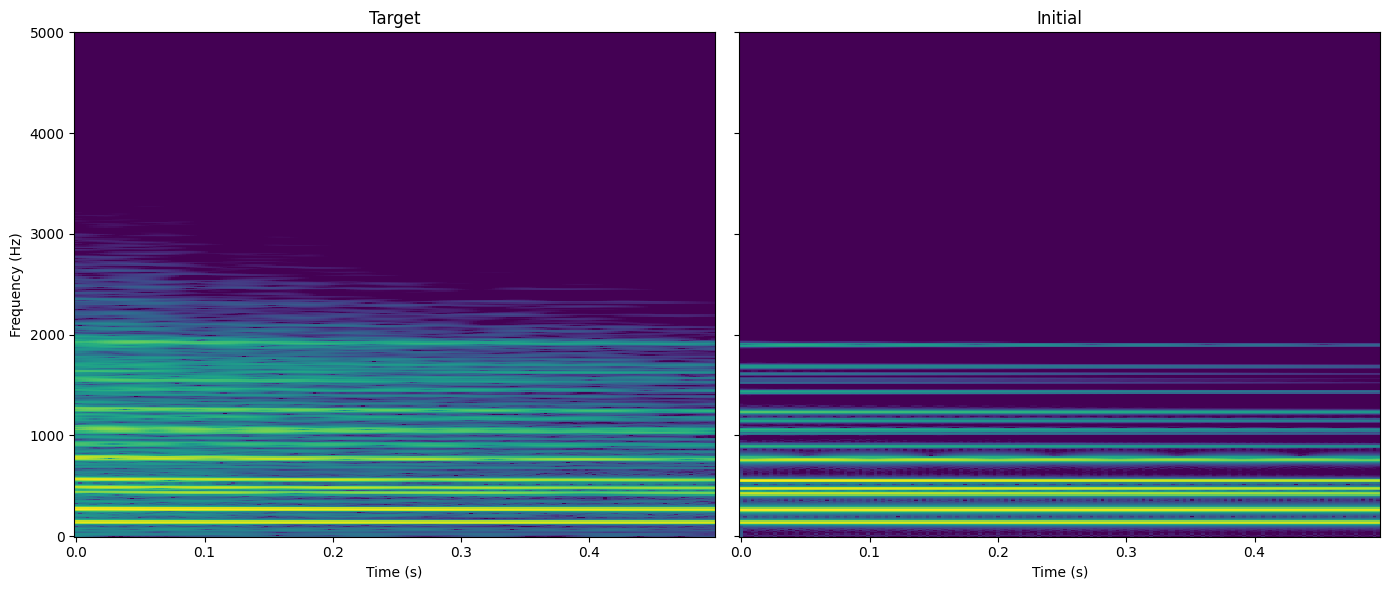

In [ ]:
# | echo: false
pars = {
    "H_opt": jax.random.uniform(jax.random.PRNGKey(0), H.shape),
}
out_pos_pred_initial_long = simulate_vkplate(pars, modal_excitation_normalised_long)
out_pos_gt_long = simulate_vkplate(gt_pars, modal_excitation_normalised_long)

n_fft = 4096
hop_length = 128
max_freq = 16000  # Maximum frequency for spectrogram
scale = 1e5

S_db_x = compute_spectrogram(
    np.array(out_pos_gt_long) * scale,
    sampling_rate,
    n_fft,
    hop_length,
    max_freq,
)

S_db_x_hat = compute_spectrogram(
    np.array(out_pos_pred_initial_long) * scale,
    sampling_rate,
    n_fft,
    hop_length,
    max_freq,
)
# Find global min and max for color bar scaling
vmin = min(S_db_x.min(), S_db_x_hat.min())
vmax = max(S_db_x.max(), S_db_x_hat.max())


# Plot side-by-side spectrograms
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)


def plot_spectrogram(ax, S_db, title):
    import librosa

    freq_bins = librosa.fft_frequencies(sr=sampling_rate, n_fft=n_fft)
    max_freq_idx = np.sum(freq_bins <= 5000)

    # Calculate time values for x-axis
    times = np.arange(S_db.shape[1]) * hop_length / sampling_rate

    img = ax.pcolormesh(
        times,  # Use time values for x-axis
        freq_bins[:max_freq_idx],  # Use frequency bins for y-axis
        S_db[:max_freq_idx],
        cmap="viridis",
        shading="auto",
        rasterized=True,
        vmin=vmin,
        vmax=vmax,
    )

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel("Time (s)")

    # Format x-axis ticks to show fewer values
    max_time = times[-1]
    # ax.set_xticks(np.linspace(0, max_time, 5))
    # ax.set_xlim(0, max_time)

    return img


# Plot spectrograms
img1 = plot_spectrogram(ax[0], S_db_x, "Target")
img2 = plot_spectrogram(ax[1], S_db_x_hat, "Initial")
ax[0].set_ylabel("Frequency (Hz)")
fig.tight_layout()
plt.show()

display_audio_with_title(out_pos_gt_long, sampling_rate, "Target")
display_audio_with_title(out_pos_pred_initial_long, sampling_rate, "Initial")

Optimisation loop


In [ ]:
# | code-fold: true

learning_rate = 5e-1
iterations = 2000
scheduler = optax.cosine_onecycle_schedule(
    transition_steps=iterations,
    peak_value=learning_rate,
)
optimiser = optax.adam(learning_rate=scheduler)
state = optimiser.init(pars)


def loss_fn(pars):
    out_pos = simulate_vkplate(pars, modal_excitation_normalised_short)
    out_pos_fft_mag = jnp.abs(stft(out_pos)) * out_pos_gt_fft_mag_scale

    ot_loss = jnp.mean(
        jax.vmap(spectral_wasserstein, in_axes=(0, 0, None, None))(
            out_pos_fft_mag,
            out_pos_gt_fft_mag,
            True,
            True,
        )
    )
    sc_loss = spectral_convergence_loss(
        out_pos_fft_mag,
        out_pos_gt_fft_mag,
    )

    return sc_loss + ot_loss


@jax.jit
def train_step(pars, state):
    loss, grads = jax.value_and_grad(loss_fn)(pars)
    updates, state = optimiser.update(grads, state, pars)
    pars = optax.apply_updates(pars, updates)
    return pars, state, loss


bar = tqdm(range(iterations))
for i in bar:
    pars, state, loss = train_step(pars, state)
    bar.set_description(f"Loss: {loss:.3f}")

  0%|          | 0/2000 [00:00<?, ?it/s]2025-04-04 12:25:52.319377: E external/xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng28{k2=1,k3=0} for conv %cudnn-conv.4 = (f32[1,1,14254]{2,1,0}, u8[0]{0}) custom-call(f32[1,1024,15277]{2,1,0} %bitcast.10872, f32[1,1024,1024]{2,1,0} %bitcast.10877), window={size=1024}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", metadata={op_name="jit(train_step)/jit(main)/conv_general_dilated" source_file="/tmp/ipykernel_116305/1382163847.py" source_line=28}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-04-04 12:25:52.603298: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.284018802s
Trying algorithm eng28{k2=1,k3=0} for conv %cudnn-conv.4 = (f32[1,1,14254]{2,1,0}, u8[0]{0}) custom-call(f32[

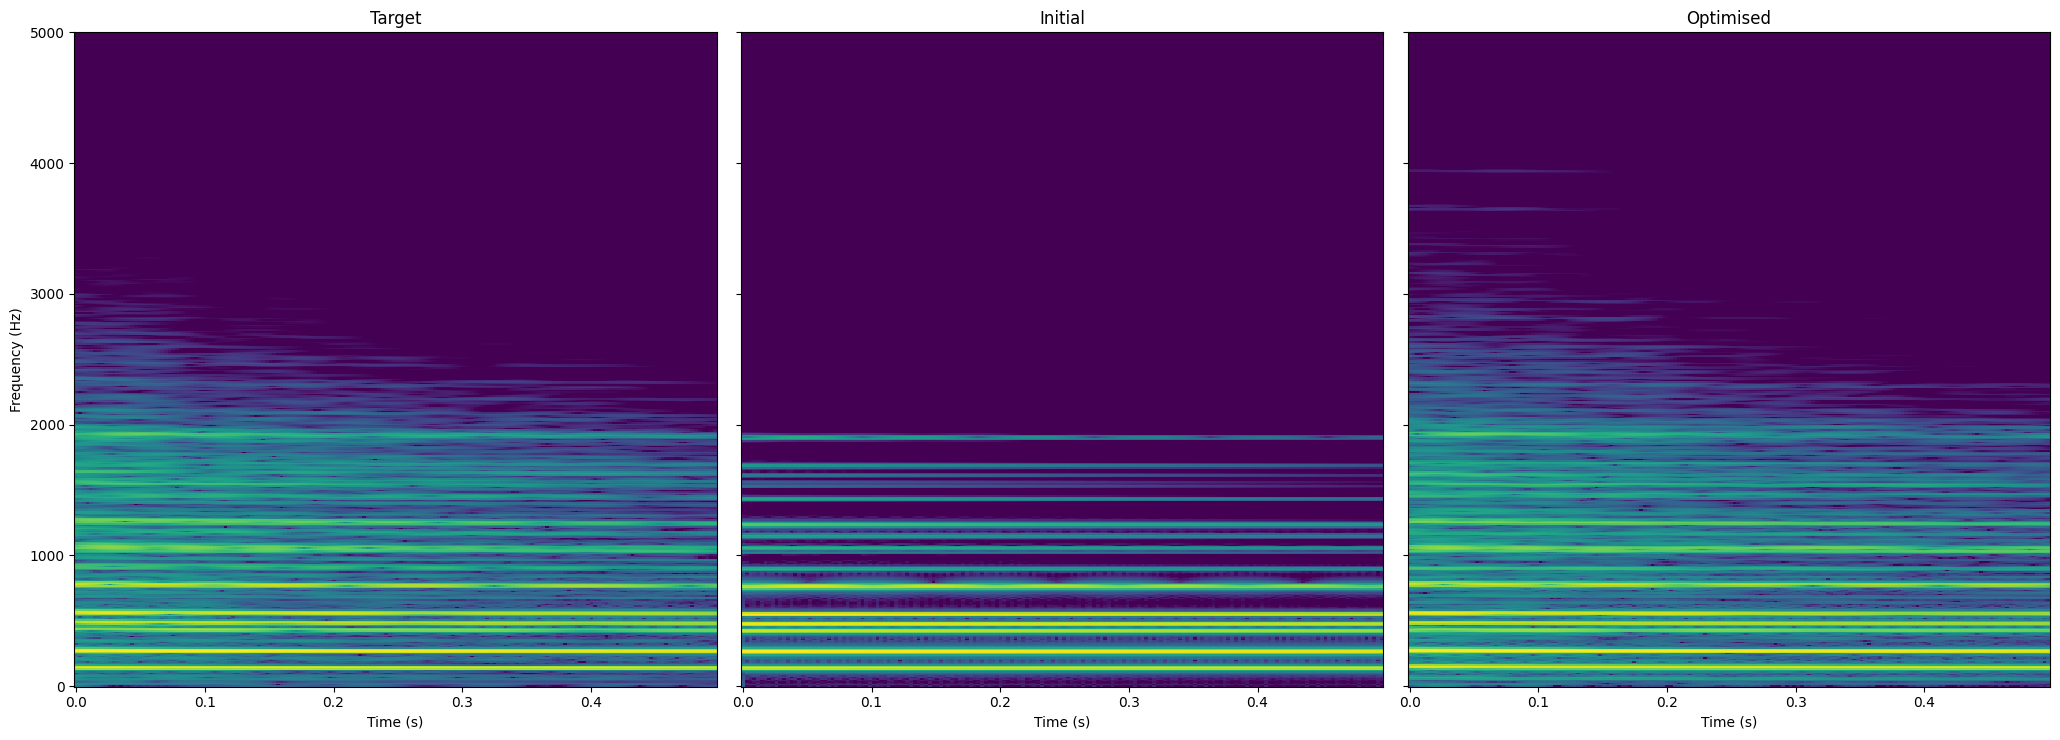

In [ ]:
# | echo: false

n_fft = 4096
hop_length = 128
max_freq = 16000
scale = 1e8

out_pos_pred_long = simulate_vkplate(pars, modal_excitation_normalised_long)
out_pos_gt_long = simulate_vkplate(gt_pars, modal_excitation_normalised_long)

S_db_x = compute_spectrogram(
    np.array(out_pos_gt_long) * scale,
    sampling_rate,
    n_fft,
    hop_length,
    max_freq,
)
S_db_x_initial = compute_spectrogram(
    np.array(out_pos_pred_initial_long) * scale,
    sampling_rate,
    n_fft,
    hop_length,
    max_freq,
)
S_db_x_hat = compute_spectrogram(
    np.array(out_pos_pred_long) * scale,
    sampling_rate,
    n_fft,
    hop_length,
    max_freq,
)
# Find global min and max for color bar scaling
vmin = min(S_db_x.min(), S_db_x_hat.min())
vmax = max(S_db_x.max(), S_db_x_hat.max())


# Plot side-by-side spectrograms
fig, ax = plt.subplots(1, 3, figsize=(6.9 * 3, 2.5 * 3), sharey=True)


# Plot spectrograms
img1 = plot_spectrogram(ax[0], S_db_x, "Target")
img2 = plot_spectrogram(ax[1], S_db_x_initial, "Initial")
img3 = plot_spectrogram(ax[2], S_db_x_hat, "Optimised")

# Only set y-label on the first plot
ax[0].set_ylabel("Frequency (Hz)")

fig.tight_layout()

plt.show()
display_audio_with_title(out_pos_gt_long, sampling_rate, "Target")
display_audio_with_title(out_pos_pred_long, sampling_rate, "Optimised")